# Amazon Review Sentiment Analysis

## Introduction

In this notebook, we perform sentiment analysis on Amazon reviews using two different approaches: VADER (Valence Aware Dictionary and sEntiment Reasoner) and RoBERTa (Robustly optimized BERT approach). Sentiment analysis is a common Natural Language Processing (NLP) task that involves determining the sentiment expressed in a piece of text, which can be positive, negative, or neutral.

### Objectives

1. **Compare Sentiment Analysis Models:** We will evaluate the performance of the VADER sentiment analysis tool and the RoBERTa model on the same dataset of Amazon reviews.
   
2. **Data Preprocessing:** Tokenize and prepare the text data for analysis.
   
3. **Apply VADER Sentiment Analysis:** Analyze sentiment scores using the VADER tool, which is designed for social media and short texts.
   
4. **Apply RoBERTa Sentiment Analysis:** Analyze sentiment using the RoBERTa model, a state-of-the-art transformer model known for its strong performance on various NLP tasks.
   
5. **Compare Results:** Compare the outputs from VADER and RoBERTa to assess their effectiveness and accuracy in sentiment classification.

### Dataset

The dataset consists of Amazon fine food reviews with associated star ratings. We will use this data to train and test the sentiment analysis models, and compare how each model interprets the sentiment expressed in the reviews. The Dataset can also be found on kaggle https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews, 
- This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

### Situation
Customer feedback is crucial for businesses to understand their strengths and areas for improvement. Amazon, being one of the largest e-commerce platforms, has a vast amount of customer reviews that can provide valuable insights if analyzed properly. However, manually analyzing thousands of reviews is impractical. Therefore, we need an automated system to determine the sentiment of these reviews efficiently.

### Task
The task is to develop a sentiment analysis model that can accurately classify Amazon product reviews as positive, negative, or neutral. This involves several steps, including data loading, preprocessing, exploratory data analysis (EDA), model building, and evaluation.

### Action
To accomplish this task, we followed these steps:


# Import necessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm.notebook import tqdm 
import torch
from transformers import AutoTokenizer, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
plt.style.use('ggplot')

# Load the dataset

In [2]:
df = pd.read_csv('Reviews.csv')

# Display the first few rows of the dataset

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
df = df.head(500)

# Exploratory Data Analysis (EDA)

<Axes: title={'center': 'Count of Reviews by Stars'}, xlabel='Score'>

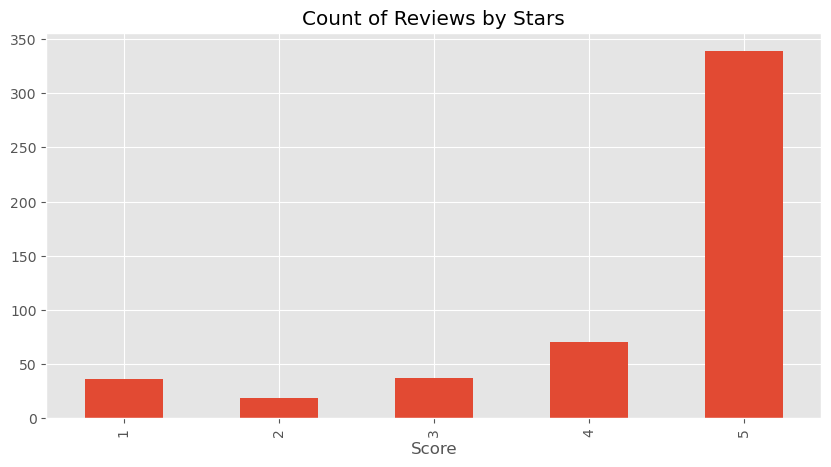

In [6]:
df['Score'].value_counts().sort_index().plot(kind = 'bar',
           title = 'Count of Reviews by Stars', 
           figsize = (10,5))

## 1. Star Rating Distribution
- 5★: 340+  |  4★: 70+  |  3★: 40+  |  2★: 20+  |  1★: 40+

- Overwhelmingly positive reviews (5-star) suggest high customer satisfaction
- The J-shaped distribution is typical for online reviews, indicating potential bias

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


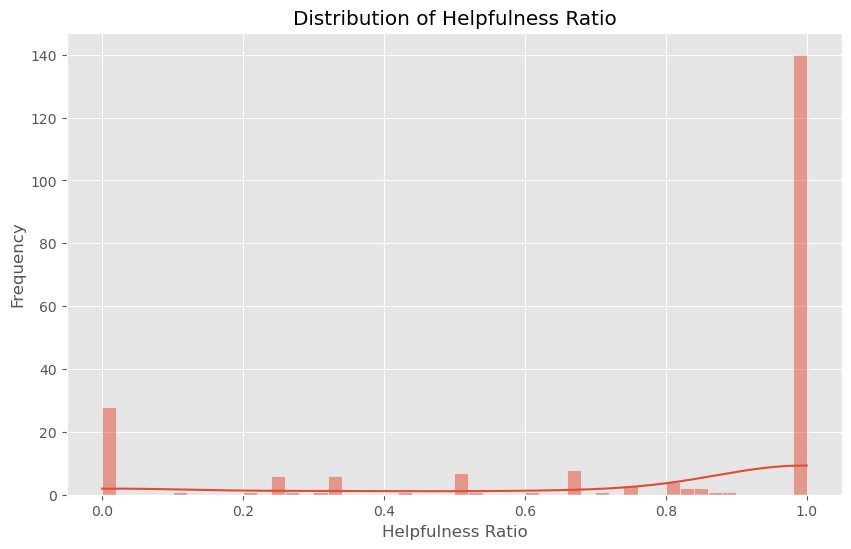

In [39]:
# Calculate the helpfulness ratio
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

# Plot the helpfulness ratio
plt.figure(figsize=(10, 6))
sns.histplot(df['HelpfulnessRatio'], bins=50, kde=True)
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')
plt.show()


## 2. Helpfulness Ratio Analysis

- Bimodal distribution with peaks at 0 and 1
- Insight: Implement a system to boost visibility of helpful reviews and filter out unhelpful ones

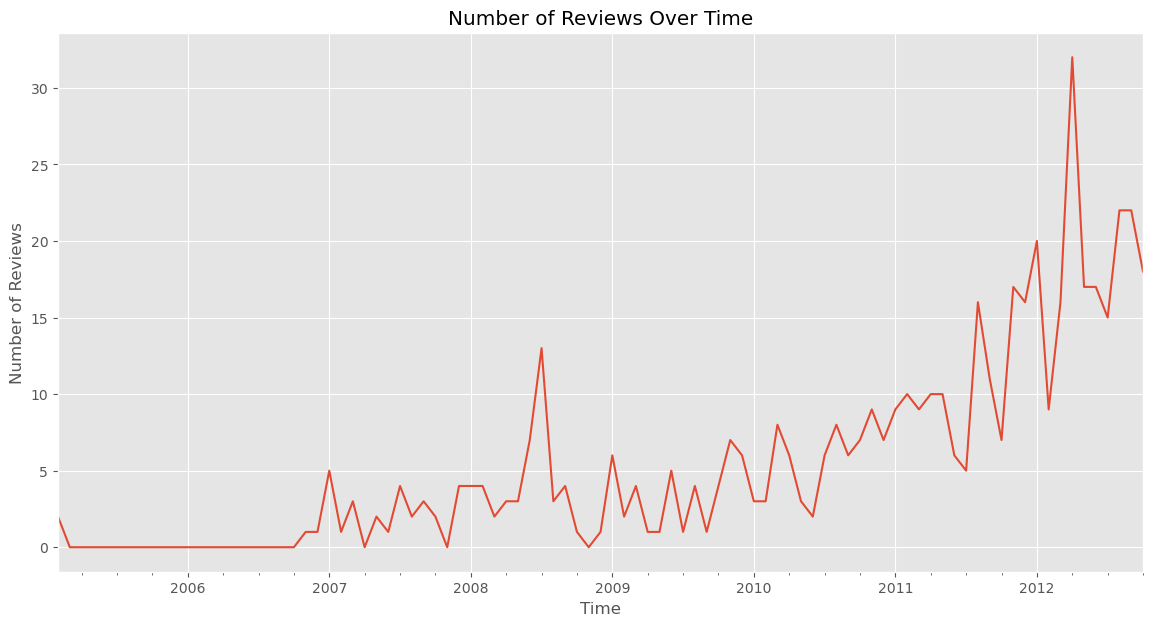

In [40]:
# Convert the timestamp to datetime
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Plot the number of reviews over time
plt.figure(figsize=(14, 7))
df.set_index('Time').resample('M').size().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()


## 3. Temporal Review Trends

- Steady growth from 2005 to 2012 with seasonal fluctuations
- Highest peak: ~32 reviews (late 2011/early 2012)
- Insight: Correlate spikes with marketing campaigns or product launches for ROI analysis

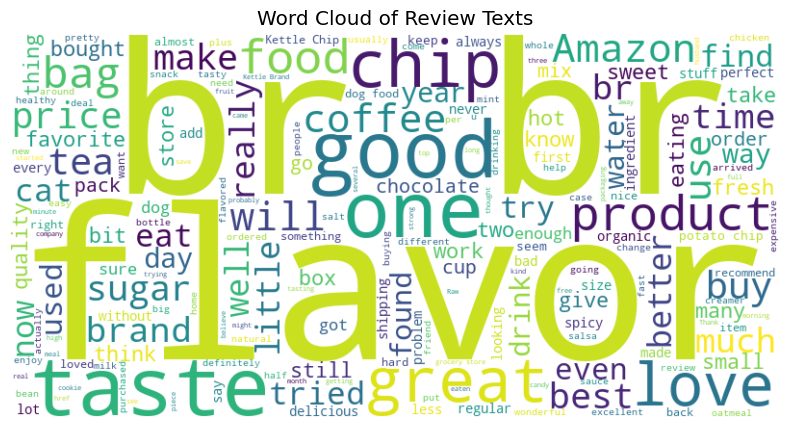

In [43]:
from wordcloud import WordCloud

# Combine all review texts
all_text = ' '.join(df['Text'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Texts')
plt.show()


## 4. Text Analysis via Word Cloud

- Dominant terms: "chip", "love", "good", "taste", "Amazon"
- Product inference: Likely a snack food item, possibly chips
- Insight: Leverage positive terminology in marketing materials and product descriptions

## NLTK

## NLTK Setup and Text Preprocessing

Before applying Natural Language Processing (NLP) techniques, we'll set up the NLTK library and preprocess the text data.


In [7]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


## Tokenization with NLTK

 We use NLTK's `word_tokenize` function to split the sample text into individual tokens. This step is essential for breaking down the text into manageable pieces for analysis. 

In [34]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

## Part-of-Speech Tagging

After tokenizing the text, we use NLTK's `pos_tag` function to assign part-of-speech tags to each token. This step helps us understand the grammatical role of each word in the sentence.

In [35]:
tagged = nltk.pos_tag(tokens)
tagged

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNPS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

## Named Entity Recognition (NER)

We use NLTK's `ne_chunk` function to perform Named Entity Recognition (NER) on the tagged tokens. NER helps in identifying and classifying named entities in the text, such as people, organizations, and locations.


In [33]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1: VADER method

## Sentiment Analysis with VADER

We download the VADER lexicon and initialize the `SentimentIntensityAnalyzer`. VADER is designed to assess sentiment in texts, particularly for social media and informal communication. It helps us determine the sentiment score of the text, classifying it as positive, negative, or neutral.


In [11]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
sia.polarity_scores('This is the best day ever!')

{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'compound': 0.6696}

## Sentiment Analysis Results

The sentiment analysis for the text "This is the best day ever!" returns the following scores:

- **Negative:** 0.0
- **Neutral:** 0.527
- **Positive:** 0.473
- **Compound:** 0.6696

**Interpretation:**
- The **negative** score is 0.0, indicating no negative sentiment.
- The **neutral** score is 0.527, suggesting that the text has a substantial neutral component.
- The **positive** score is 0.473, showing a strong positive sentiment.
- The **compound** score is 0.6696, which is a summary measure of the overall sentiment, indicating a generally positive sentiment.

These scores help us understand the emotional tone of the text and its overall sentiment.


# Run polarity score on entire dataset

In [15]:
res = {}
for i, row in tqdm(df.iterrows(), total= len(df)) :
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
res

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441},
 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664},
 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265},
 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468},
 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883},
 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346},
 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487},
 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369},
 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313},
 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746},
 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579},
 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296},
 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466},
 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486},
 

In [17]:
pd.DataFrame(res)

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
neg,0.0000,0.1380,0.0910,0.0,0.0000,0.029,0.0340,0.0000,0.0000,0.0000,...,0.0550,0.0000,0.0560,0.1000,0.0000,0.0000,0.0590,0.0250,0.041,0.0000
neu,0.6950,0.8620,0.7540,1.0,0.5520,0.809,0.6930,0.5200,0.8510,0.7050,...,0.7040,0.7170,0.8550,0.6450,0.7880,0.5540,0.7990,0.7620,0.904,0.6780
pos,0.3050,0.0000,0.1550,0.0,0.4480,0.163,0.2730,0.4800,0.1490,0.2950,...,0.2410,0.2830,0.0890,0.2540,0.2120,0.4460,0.1420,0.2120,0.055,0.3220
compound,0.9441,-0.5664,0.8265,0.0,0.9468,0.883,0.9346,0.9487,0.6369,0.8313,...,0.9287,0.9367,0.5976,0.6486,0.9743,0.9725,0.7833,0.9848,0.128,0.9811


In [18]:
# Create vaders DataFrame
vaders = pd.DataFrame(res).T
vaders  = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how = 'left')

In [19]:
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.554,0.446,0.9725,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.059,0.799,0.142,0.7833,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,0.025,0.762,0.212,0.9848,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,0.041,0.904,0.055,0.1280,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

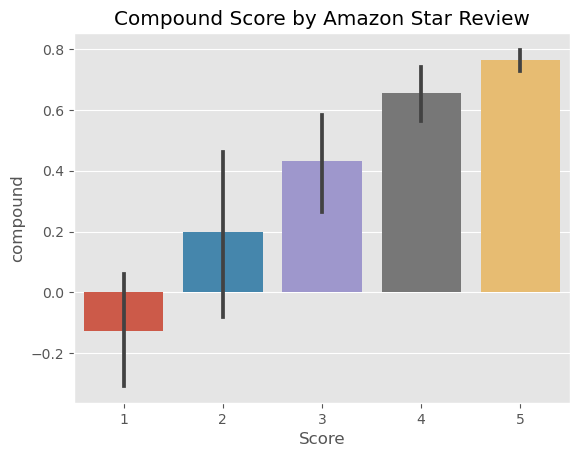

In [20]:
ax = sns.barplot(data = vaders, x= 'Score', y = 'compound')
ax.set_title('Compound Score by Amazon Star Review')

<Axes: xlabel='Score', ylabel='pos'>

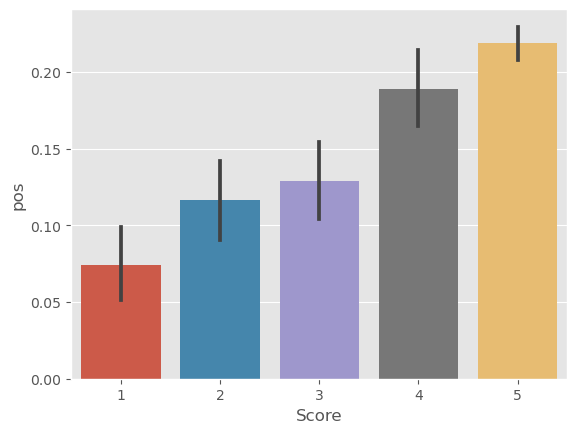

In [21]:
az  = sns.barplot(data = vaders, x = 'Score', y='pos')
az

# Step 2: Roberta Pretrained Model

## Model Initialization

We initialize the RoBERTa-based sentiment analysis model from the Cardiff NLP repository. The `AutoTokenizer` and `AutoModelForSequenceClassification` are loaded to handle the tokenization and sequence classification tasks.

**Purpose:**
This setup prepares us to perform sentiment analysis using a state-of-the-art model specifically trained for sentiment classification on Twitter data. It allows us to analyze text with advanced deep learning techniques.


In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores
scores_dict = {
    'roberta_neg' :scores[0],
    'roberta_neu' :scores[1],
    'roberta_pos' :scores[2]
    
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}


In [25]:
def polarity_scores_roberta(example): 
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores
    scores_dict = {
        'roberta_neg' :scores[0],
        'roberta_neu' :scores[1],
        'roberta_pos' :scores[2]
        
    }
    return scores_dict

In [26]:
res = {}
for i, row in tqdm(df.iterrows(), total= len(df)) :
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError: 
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [27]:
both

{'vader_neg': 0.0,
 'vader_neu': 0.678,
 'vader_pos': 0.322,
 'vader_compound': 0.9811,
 'roberta_neg': 0.0024397573,
 'roberta_neu': 0.01132722,
 'roberta_pos': 0.986233}

In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index' : 'Id'})
results_df = results_df.merge(df, how = 'left')

In [29]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Comparison 

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

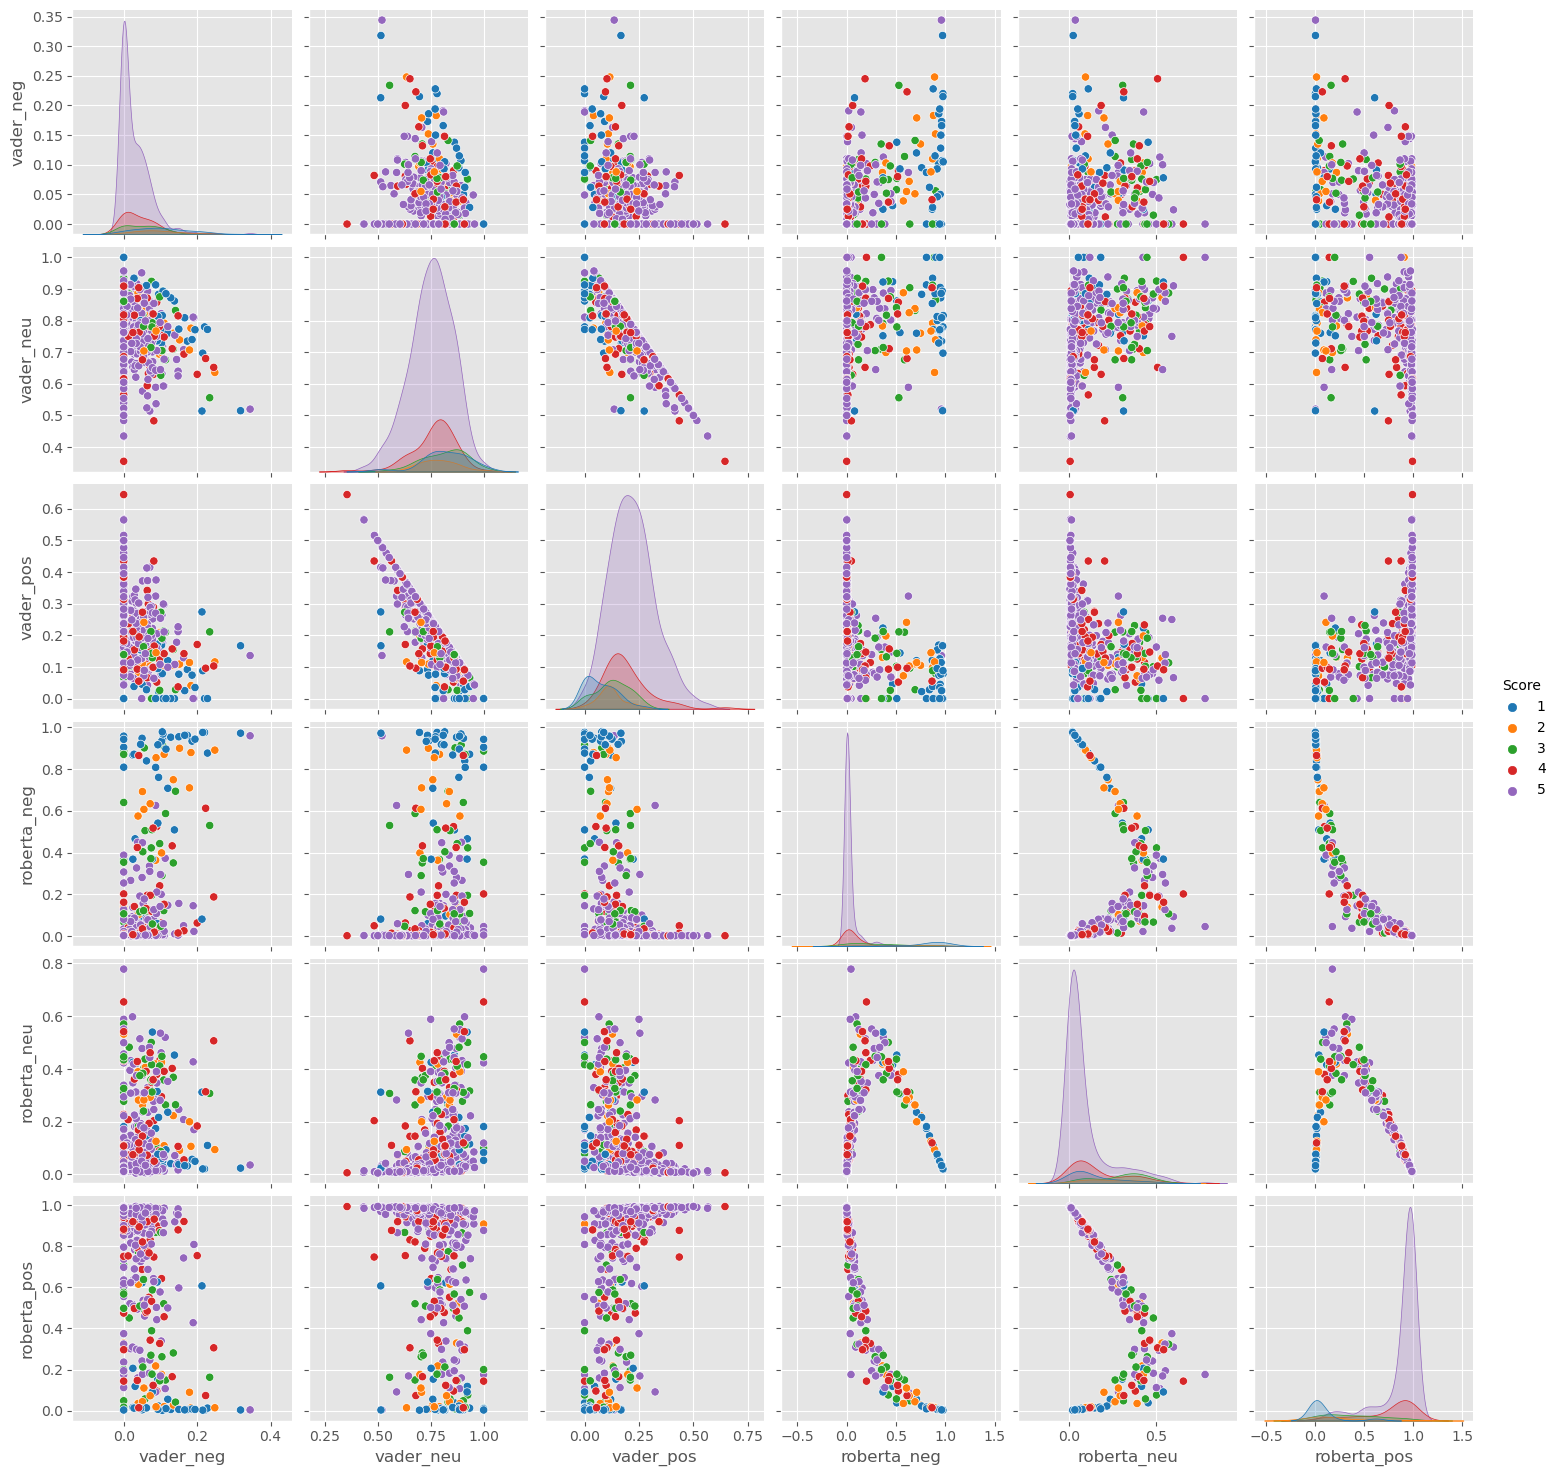

In [30]:
sns.pairplot(data = results_df, vars=['vader_neg',	'vader_neu',	'vader_pos',	'roberta_neg','roberta_neu' ,	'roberta_pos'],
            hue='Score', 
            palette = 'tab10')
plt.show()

## Visualization of Sentiment Scores

We use a pair plot to visualize the relationships between various sentiment scores generated by VADER and RoBERTa models. The plot displays pairwise comparisons of the sentiment metrics:

- **VADER Scores:** Negative, Neutral, Positive
- **RoBERTa Scores:** Negative, Neutral, Positive

**Plot Details:**
- **Hue:** Represents different review scores (e.g., star ratings)
- **Palette:** 'tab10' for distinct color coding

**Purpose:**
This visualization helps in examining how different sentiment scores correlate with each other and with the review scores. It provides insights into the consistency and differences between the two sentiment analysis models.


## 1. Sentiment Analysis Metrics:


- The 'vader' and 'roberta' prefixes likely refer to different sentiment analysis tools (VADER and RoBERTa).
- These metrics measure negative, neutral, and positive sentiment, as well as compound scores.


## 2. Correlation Patterns:


- Strong positive correlation between Score and vader_pos/roberta_pos, visible as upward-trending clusters.
- Negative correlation between Score and vader_neg/roberta_neg, shown as downward-trending patterns.
- These correlations confirm that higher star ratings generally correspond with more positive sentiment in the review text.


## 3. Clustering:


- Distinct clusters are visible in several plots, particularly those involving the Score variable.
- These clusters often align with the discrete star ratings (1-5), showing how sentiment metrics vary across rating levels.


## 4. Density Distribution:


- The diagonal of the matrix shows the distribution of each variable.
- Score distribution reaffirms the J-shaped pattern seen in the bar chart, with a high concentration of 5-star reviews.


## 5. Outliers and Spread:


- Some plots show clear outliers or wider spreads, indicating variability in sentiment even within the same star rating.
- This suggests nuanced differences in review content that aren't captured by the star rating alone.


## 6. Tool Comparison:


- By comparing VADER and RoBERTa metrics, we can see how different sentiment analysis tools assess the same reviews.
- This comparison could be valuable for evaluating and refining sentiment analysis methodologies.

# Example

In [31]:
results_df.query('Score ==1').sort_values('vader_pos', ascending = False)['Text'].values[10]

"These singles sell for $2.50 - $3.36 at the store for 1 box of 24 singles. I'm not sure why Amazon is selling it for $9.99 for a box of 24 singles.  Hazelnut coffee creamer is my favorite, but truly this is not a good buy."

## Sample Review with Highest Positive VADER Score

We query the dataset to find and display a review with a score of 1 (indicating the lowest rating) and the highest positive sentiment score according to VADER.
This review illustrates a case where a low-rated product still has a high positive sentiment score according to VADER. Analyzing such reviews helps us understand potential discrepancies between sentiment analysis results and actual review ratings, providing insights into the effectiveness and limitations of the sentiment analysis models.

In [32]:
results_df.query('Score ==1').sort_values('roberta_pos', ascending = False)['Text'].values[10]

'The package came with the label torn off and no cooking instructions. I know how I normally cook Couscous so tried 3/4 cup water to 1 cup couscous-brought to a boil and let sit, covered for 5min. It was mushy and tasteless.We have thrown out the rest of the container.'

## Sample Review with Highest Positive RoBERTa Score

We query the dataset to find and display a review with a score of 1 (indicating the lowest rating) and the highest positive sentiment score according to the RoBERTa model.
This review shows a low-rated product with a high positive sentiment score according to RoBERTa. Examining such reviews helps us understand how the sentiment analysis model's results might differ from actual ratings, offering insights into the model's accuracy and the potential need for further calibration.

## Conclusion

In this notebook, we performed sentiment analysis on Amazon reviews using two different approaches: VADER and RoBERTa. We compared the results of these models to understand their effectiveness and identify any discrepancies.

**Key Findings:**
- **VADER Analysis:** Provided sentiment scores including negative, neutral, positive, and a compound score. VADER was particularly effective for quick sentiment assessments and worked well with social media-like text.
- **RoBERTa Analysis:** Offered a more nuanced understanding of sentiment, leveraging a deep learning model tailored for sentiment classification. It provided detailed sentiment scores and highlighted differences in how sentiment is perceived across models.

**Insights:**
- We observed cases where the sentiment scores did not align with the review ratings, illustrating the challenges of sentiment analysis.
- The pair plot and specific review examples revealed interesting patterns and discrepancies, highlighting the importance of model choice in sentiment analysis.

**Future Work:**
- **Model Improvement:** Explore additional sentiment analysis models and techniques to enhance accuracy and robustness.
- **Dataset Expansion:** Analyze a larger and more diverse dataset to generalize findings and improve model performance.

Thank you for reviewing this notebook. If you have any questions or suggestions, feel free to reach out.
